In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import numpy as np

In [2]:
def _check_not_tuple_of_2_elements(obj, obj_name='obj'):
    """Check object is not tuple or does not have 2 elements."""
    if not isinstance(obj, tuple) or len(obj) != 2:
        raise TypeError('%s must be a tuple of 2 elements.' % obj_name)


def _float2str(value, precision=None):
    return ("{0:.{1}f}".format(value, precision)
            if precision is not None and not isinstance(value, string_type)
            else str(value))

In [3]:
def plot_importance(importance, feature_name, out_fname, ax=None, height=0.2,
                    xlim=None, ylim=None, title='Feature importance',
                    xlabel='Feature importance', ylabel='Features',
                    importance_type='split', max_num_features=None,
                    ignore_zero=True, figsize=None, dpi=None, grid=True,
                    precision=3, **kwargs):
    
    import matplotlib.pyplot as plt
    import numpy as np
    zip_ = zip

#     importance = booster.feature_importance(importance_type=importance_type)
#     feature_name = booster.feature_name()

    if not len(importance):
        raise ValueError("Booster's feature_importance is empty.")

    tuples = sorted(zip_(feature_name, importance), key=lambda x: x[1])
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
    if max_num_features is not None and max_num_features > 0:
        tuples = tuples[-max_num_features:]
    labels, values = zip_(*tuples)

    if ax is None:
        if figsize is not None:
            _check_not_tuple_of_2_elements(figsize, 'figsize')
        _, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=height, **kwargs)

    for x, y in zip_(values, ylocs):
        ax.text(x + 1, y,
                _float2str(x, precision) if importance_type == 'gain' else x,
                va='center')

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)

    if xlim is not None:
        _check_not_tuple_of_2_elements(xlim, 'xlim')
    else:
        xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)

    if ylim is not None:
        _check_not_tuple_of_2_elements(ylim, 'ylim')
    else:
        ylim = (-1, len(values))
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title + f' - {out_fname}')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(grid)
    plt.savefig(f'{out_fname}.png')
    return ax

In [7]:
f_path = './pretrained/SA/'

In [9]:
model_paths = [f_path + m for m in os.listdir(f_path)]

In [12]:
model_paths

['./pretrained/SA/emot',
 './pretrained/SA/cult_only',
 './pretrained/SA/nogeo',
 './pretrained/SA/pos',
 './pretrained/SA/syn_only',
 './pretrained/SA/mwe_no_norm',
 './pretrained/SA/emot_norm',
 './pretrained/SA/mwe',
 './pretrained/SA/base']

In [69]:
m_path = model_paths[8]
models = [os.path.join(m_path, f) for f in os.listdir(m_path) if f.endswith('.txt')]

In [70]:
pooled_importance = defaultdict(list)
for m in models:
    bst = lgb.Booster(model_file=m)
    names = bst.feature_name()
    impt_vals = bst.feature_importance(importance_type='split')
    for n, i in zip(names, impt_vals):
        pooled_importance[n].append(i)

In [71]:
avg_importance = [(k, np.round(np.mean(v), 2)) for k, v in pooled_importance.items()]

In [72]:
name, impt = tuple(zip(*avg_importance))

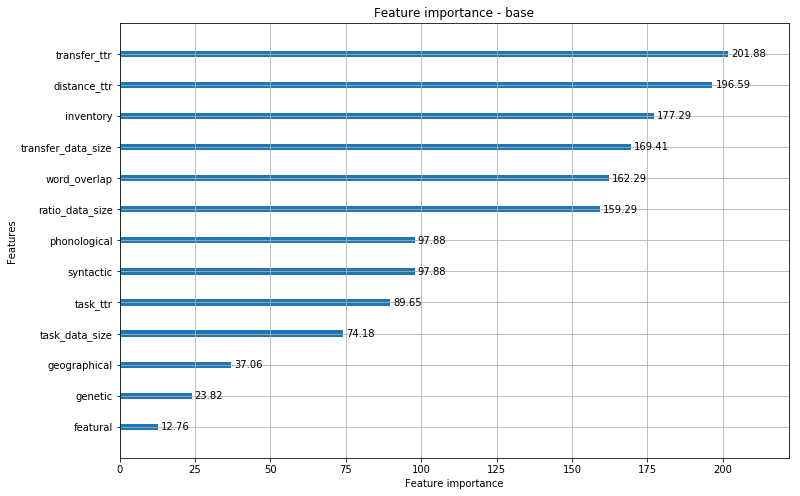

In [73]:
model_name = m_path.split('/')[-1]
plot_importance(impt, name, model_name, figsize=(12, 8))